In [1]:
import re

import numpy as np
import pandas as pd
import utils
import pyproj
import json

from consts import *

In [2]:
metadata = pd.read_csv(
    DATA_DIR.joinpath("metadata.csv"),
    usecols=["GMLID", "ADDRESS_STREET", "ADDRESS_HOUSE_NUMBER", "ADDRESS_CITY", "EXTERNAL_REFERENCE_NAME", "area", "yearly_kwh"]
)


In [3]:
metadata.describe()


,area,yearly_kwh
count,20742.000000,2.074200e+04
mean,242.994154,4.271699e+04
std,698.340183,1.345768e+05
min,0.000000,0.000000e+00
25%,47.972500,8.399095e+03
50%,134.780000,2.197285e+04
75%,218.280000,3.552537e+04
max,36618.550000,7.202709e+06


In [4]:
metadata = metadata[metadata["yearly_kwh"] != 0]


In [5]:
def match_regex(regex, string):
    match = re.search(regex, string)
    if match:
        return match.group(0)
    else:
        return np.nan


In [6]:
metadata["ehr_code"] = metadata["EXTERNAL_REFERENCE_NAME"].apply(
    lambda x: match_regex(r"[0-9]{9}", x))
metadata[ETAK_ID] = metadata["GMLID"].apply(lambda x: x.split("_")[1])
metadata["address_id"] = metadata["EXTERNAL_REFERENCE_NAME"].apply(
    lambda x: match_regex(r"[A-Z]{2}[0-9]+", x))


In [7]:
metadata.drop(columns=["EXTERNAL_REFERENCE_NAME", "GMLID"], inplace=True)


In [8]:
metadata[ADDRESS] = metadata["ADDRESS_STREET"] + " " + \
    metadata["ADDRESS_HOUSE_NUMBER"] + ", " + metadata["ADDRESS_CITY"]
metadata.drop(columns=["ADDRESS_STREET", "ADDRESS_HOUSE_NUMBER",
              "ADDRESS_CITY", "yearly_kwh"], inplace=True)


In [9]:
metadata.head()


,area,ehr_code,etak_id,address_id,address
0,123.77,104040745,727906,EE00772848,"Sepikoja tänav 7, Tartu linn"
1,133.98,104043422,730967,EE00775324,"Kungla tänav 6, Tartu linn"
2,92.54,NaN,729069,ME03027847,"Ööbiku tänav 20, Tartu linn"
3,205.68,104014518,710902,EE00748624,"Peetri tänav 53, Tartu linn"
4,187.61,104042819,718550,EE00774751,"Kopli tänav 13, Tartu linn"


In [10]:
metadata_ehr_nan = metadata[metadata["ehr_code"].isna()]


In [11]:
print(f"{metadata_ehr_nan.shape[0] / metadata.shape[0] * 100:.2f}% of data has no ehr code")


32.68% of data has no ehr code


In [12]:
etak_ids = metadata[ETAK_ID].unique()


In [13]:
etak_ids.size


20730

In [14]:
estimated_production_by_building = pd.read_csv(BUILDINGS_PATH)


In [15]:
estimated_production_by_building.columns

Index(['etak_id', 'lat', 'lon', 'total_roof_area', 'district', 'annual_kwh',
       'pv_area_m2', 'annual_kwh/pv_m2', 'Jan_kwh', 'Feb_kwh', 'Mar_kwh',
       'Apr_kwh', 'May_kwh', 'Jun_kwh', 'Jul_kwh', 'Aug_kwh', 'Sep_kwh',
       'Oct_kwh', 'Nov_kwh', 'Dec_kwh', 'Jan_kwh/pv_m2', 'Feb_kwh/pv_m2',
       'Mar_kwh/pv_m2', 'Apr_kwh/pv_m2', 'May_kwh/pv_m2', 'Jun_kwh/pv_m2',
       'Jul_kwh/pv_m2', 'Aug_kwh/pv_m2', 'Sep_kwh/pv_m2', 'Oct_kwh/pv_m2',
       'Nov_kwh/pv_m2', 'Dec_kwh/pv_m2'],
      dtype='object')

In [16]:
estimated_production_by_building.shape


(20884, 32)

In [17]:
estimated_production_by_building[ETAK_ID] = estimated_production_by_building[ETAK_ID].astype(str)


In [18]:
estimated_production_by_building = estimated_production_by_building[estimated_production_by_building[ETAK_ID].isin(etak_ids)]


In [19]:
estimated_production_by_building.shape


(20729, 32)

In [20]:
estimated_production_by_building_mapped = estimated_production_by_building.merge(metadata, on=ETAK_ID)


In [21]:
(estimated_production_by_building_mapped[TOTAL_ROOF_AREA] - estimated_production_by_building_mapped["area"]).mean()


2.8944956341530004e-06

In [22]:
estimated_production_by_building_mapped.drop(columns=["area"], inplace=True)


In [23]:
address_id_nan_condition = estimated_production_by_building_mapped["address_id"].isna()
ehr_code_nan_condition = estimated_production_by_building_mapped["ehr_code"].isna()
address_nan_condition = estimated_production_by_building_mapped[ADDRESS].isna()

In [24]:
estimated_production_by_building_mapped[address_id_nan_condition].shape

(1993, 35)

In [25]:
ehr_code_nan = estimated_production_by_building_mapped[ehr_code_nan_condition]
ehr_code_nan.shape

(6775, 35)

In [26]:
estimated_production_by_building_mapped[address_nan_condition].shape

(2641, 35)

In [27]:
all_metadata_nan = estimated_production_by_building_mapped[address_id_nan_condition & ehr_code_nan_condition & address_id_nan_condition]
all_metadata_nan.shape

(1993, 35)

In [28]:
all_metadata_nan.describe()

,lat,lon,total_roof_area,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,Mar_kwh,Apr_kwh,...,Mar_kwh/pv_m2,Apr_kwh/pv_m2,May_kwh/pv_m2,Jun_kwh/pv_m2,Jul_kwh/pv_m2,Aug_kwh/pv_m2,Sep_kwh/pv_m2,Oct_kwh/pv_m2,Nov_kwh/pv_m2,Dec_kwh/pv_m2
count,1993.000000,1993.000000,1993.000000,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,...,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,58.371022,26.711643,42.887316,7.914831e+03,38.598584,202.128814,140.118716,356.323076,687.262659,950.060296,...,17.327437,24.256550,30.818142,30.160316,29.937068,25.068845,17.706836,9.360216,3.222313,2.030784
std,0.019322,0.047315,195.102167,3.817475e+04,175.591950,25.955449,758.313444,1894.373510,3466.459678,4597.441525,...,3.738928,3.193135,2.444470,1.698224,1.932068,2.595971,3.139493,2.418819,1.085717,0.908946
min,58.340058,26.512274,2.790000,2.685400e+02,2.511000,58.432827,1.490000,5.460000,17.840000,31.080000,...,3.752317,6.061055,9.562477,11.826721,10.773699,7.230256,4.301075,2.075264,0.560967,0.185786
25%,58.354750,26.698597,22.690000,4.160010e+03,20.421000,178.377609,48.380000,140.420000,332.530000,499.520000,...,13.508308,21.484427,29.586403,30.158401,29.405462,23.139022,14.608126,6.842942,2.115630,1.092643
50%,58.368162,26.717071,25.470000,4.681170e+03,22.923000,221.560349,90.890000,221.880000,411.720000,561.530000,...,20.177005,26.483831,32.008581,30.688803,30.858628,26.840520,20.121827,11.241949,4.036986,2.756647
75%,58.383956,26.732496,28.800000,5.419920e+03,25.920000,222.139537,109.520000,266.370000,486.840000,651.850000,...,20.300875,26.678193,32.300415,30.740589,30.874384,26.927615,20.200406,11.375241,4.133566,2.785705
max,58.451788,26.795951,7384.310000,1.463915e+06,6645.879000,222.423101,29442.820000,73575.940000,133951.310000,176505.810000,...,20.727560,26.773212,32.940379,32.083777,31.810176,27.043667,20.324544,11.816528,4.529524,3.300317


In [29]:
ehr_code_nan.describe()

,lat,lon,total_roof_area,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,Mar_kwh,Apr_kwh,...,Mar_kwh/pv_m2,Apr_kwh/pv_m2,May_kwh/pv_m2,Jun_kwh/pv_m2,Jul_kwh/pv_m2,Aug_kwh/pv_m2,Sep_kwh/pv_m2,Oct_kwh/pv_m2,Nov_kwh/pv_m2,Dec_kwh/pv_m2
count,6775.000000,6775.000000,6775.000000,6.775000e+03,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.00000,...,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000,6775.000000
mean,58.372854,26.707641,76.591637,1.346985e+04,68.932473,199.444317,219.880700,567.173252,1134.172965,1612.90463,...,17.028239,23.907972,30.461891,29.869928,29.625873,24.750191,17.437023,9.209397,3.163692,1.990318
std,0.018668,0.050542,220.158183,3.937644e+04,198.142364,27.375075,669.300638,1708.766722,3339.782344,4726.94974,...,3.802697,3.398143,2.773049,1.992186,2.236829,2.837888,3.228194,2.421757,1.071416,0.891712
min,58.334260,26.482851,2.020000,1.193700e+02,1.818000,42.417103,0.990000,2.890000,7.670000,12.38000,...,2.707970,4.451231,6.998255,8.651348,7.800078,5.259841,3.123909,1.477603,0.430483,0.158038
25%,58.359244,26.698724,25.935000,4.875175e+03,23.341500,175.972907,84.870000,220.340000,428.665000,584.52500,...,13.284142,21.106292,29.021372,29.671123,28.883785,22.702844,14.394725,6.763695,2.105943,1.101222
50%,58.371497,26.716800,38.070000,6.788860e+03,34.263000,220.531026,113.000000,287.770000,574.890000,813.97000,...,19.808457,26.475291,32.004849,30.688701,30.822416,26.734509,20.050659,11.210757,3.991247,2.632832
75%,58.384050,26.732149,64.865000,1.128859e+04,58.378500,222.112319,184.010000,471.620000,951.915000,1352.19500,...,20.298222,26.677013,32.298622,30.699600,30.870082,26.928606,20.199003,11.375144,4.129892,2.786270
max,58.452001,26.795951,7384.310000,1.463915e+06,6645.879000,222.423101,29442.820000,73575.940000,133951.310000,176505.81000,...,20.799844,26.777038,32.957644,32.149317,31.861928,27.048349,20.324544,11.816528,4.593266,3.408211


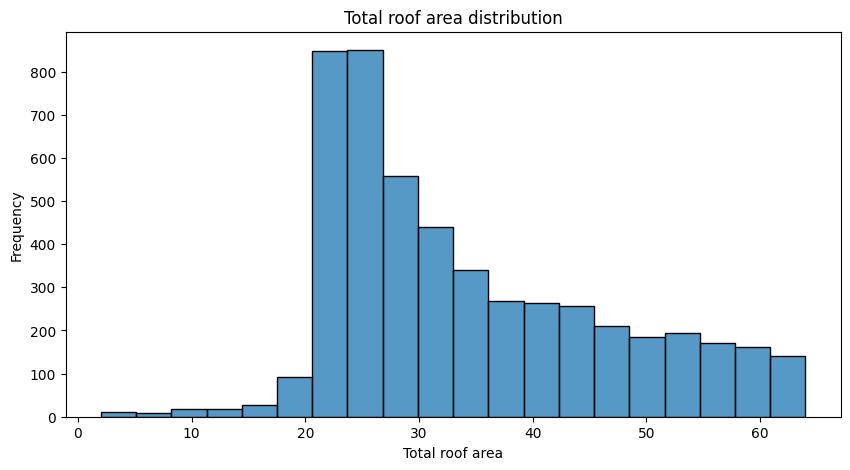

In [30]:
utils.plot_hist(
    ehr_code_nan[ehr_code_nan[TOTAL_ROOF_AREA] < 64][TOTAL_ROOF_AREA],
    "Total roof area distribution", 
    "Total roof area", 
    "Frequency",
    bins=20
)

In [31]:
buildings_with_ehr = estimated_production_by_building_mapped[estimated_production_by_building_mapped["ehr_code"].notna()]

In [32]:
buildings_with_ehr.shape

(13954, 35)

In [ ]:
metadata_results = await utils.find_metadata(buildings_with_ehr)

In [ ]:
entries = []
for item in metadata_results:
    try:
        building_data = item[1]["ehitis"]["ehitiseAndmed"]
        name = building_data.get("nimetus", np.nan)
        type = building_data.get("kaosIdTxt", np.nan)
        year = building_data.get("esmaneKasutus", np.nan)

        building_basic_data = item[1]["ehitis"]["ehitisePohiandmed"]
        building_basic_data_keys = building_basic_data.keys()
        area = building_basic_data.get("suletud_netopind", None)
        floors = building_basic_data.get("maxKorrusteArv", None)

        building_energy_labels = item[1]["ehitis"]["ehitiseEnergiamargised"]["energiamargis"]
        
        if building_energy_labels:
            energy_label = ",".join({item["energiaKlass"] for item in building_energy_labels})
        else:
            energy_label = np.nan

        building_uses = item[1]["ehitis"]["ehitiseKasutusotstarbed"]["kasutusotstarve"]
        if building_uses:
            for building_use in building_uses:
                purpose = building_use["kaosIdTxt"]
                residential_area = building_use["eluruumidePind"]
                non_residential_area = building_use["mitteeluruumidePind"]
                entries.append(
                    {   
                        "id": item[0],
                        "name": name, 
                        "type": type, 
                        "year": year if year else np.nan,
                        "total_area": float(area) if area else np.nan,
                        "floors": int(floors) if floors else np.nan,
                        "energy_label": energy_label,
                        "purpose": purpose,
                        "residential_area": float(residential_area) if residential_area else 0.0,
                        "non-residential_area": float(non_residential_area) if non_residential_area else 0.0
                    }
                )
            
        else:
            entries.append(
                    {   
                        "id": item[0],
                        "name": name, 
                        "type": type, 
                        "year": year if year else np.nan,
                        "total_area": float(area) if area else np.nan,
                        "floors": int(floors) if floors else np.nan,
                        "energy_label": energy_label,
                        "purpose": np.nan,
                        "residential_area": np.nan,
                        "non-residential_area": np.nan
                    }
            )
    except KeyError as e:
        entries.append(
            {   
                "id": item[0],
                "name": np.nan, 
                "type": np.nan, 
                "year": np.nan,
                "total_area": np.nan,
                "floors": np.nan,
                "energy_label": np.nan,
                "purpose": np.nan,
                "residential_area": np.nan,
                "non-residential_area": np.nan
            }
        )

In [ ]:
buildings_metadata = pd.DataFrame(entries)

In [ ]:
buildings_metadata.head()

,id,name,type,year,total_area,floors,energy_label,purpose,residential_area,non-residential_area
0,EE03737345,Üksikelamu,Üksikelamu,2020,225.6,2.0,NaN,Üksikelamu,169.6,0.0
1,EE00752942,Üksikelamu,Üksikelamu,1977,131.2,2.0,NaN,Üksikelamu,123.4,0.0
2,EE00994444,üksikelamu,Üksikelamu,2009,182.9,1.0,NaN,Üksikelamu,154.0,0.0
3,EE00775236,üksikelamu,Üksikelamu,1958,168.7,2.0,NaN,Üksikelamu,168.7,0.0
4,EE03245349,aiamaja,"Suvila, aiamaja",1988,80.5,1.0,NaN,"Suvila, aiamaja",80.5,0.0


In [ ]:
buildings_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17971 entries, 0 to 17970
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    17971 non-null  object 
 1   name                  17837 non-null  object 
 2   type                  17837 non-null  object 
 3   year                  15194 non-null  object 
 4   total_area            17692 non-null  float64
 5   floors                17710 non-null  float64
 6   energy_label          2286 non-null   object 
 7   purpose               17839 non-null  object 
 8   residential_area      17839 non-null  float64
 9   non-residential_area  17839 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.4+ MB


In [ ]:
buildings_metadata = buildings_metadata[~(
    (buildings_metadata["total_area"].isna()) & (buildings_metadata["residential_area"] == 0.0) & (buildings_metadata["non-residential_area"] == 0.0) 
)]

In [ ]:
buildings_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17851 entries, 0 to 17970
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    17851 non-null  object 
 1   name                  17717 non-null  object 
 2   type                  17717 non-null  object 
 3   year                  15100 non-null  object 
 4   total_area            17692 non-null  float64
 5   floors                17683 non-null  float64
 6   energy_label          2286 non-null   object 
 7   purpose               17719 non-null  object 
 8   residential_area      17719 non-null  float64
 9   non-residential_area  17719 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.5+ MB


In [ ]:
buildings_metadata = buildings_metadata[buildings_metadata["total_area"].notna()]

In [ ]:
buildings_metadata["purpose"].value_counts().to_frame().to_csv(BUILDINGS_DIR.joinpath("building_purposes.csv"))

In [ ]:
with open(BUILDINGS_DIR.joinpath("building_purposes.json"), 'r') as f:
    purpose_to_class = json.load(f)

In [ ]:
buildings_metadata["class"] = buildings_metadata["purpose"].map(lambda value: purpose_to_class.get(value))


In [ ]:
buildings_metadata["area"] = buildings_metadata["residential_area"] + buildings_metadata["non-residential_area"]

In [ ]:
pivot_df = pd.pivot_table(buildings_metadata, index='id', columns='class', values='area', aggfunc='sum', fill_value=0)


In [ ]:
pivot_df.head(1)

class,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
id,,,,,,,,,
EE00747614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.6,0.0


In [ ]:
pivot_df.shape

(13677, 10)

In [ ]:
pivot_df.rename_axis(None, axis=1, inplace=True)
pivot_df.reset_index(inplace=True)

In [ ]:
pivot_df.head(1)

,id,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
0,EE00747614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.6,0.0


In [ ]:
buildings_metadata_no_duplicates = buildings_metadata[['id', 'name', 'type', 'year', 'total_area', 'floors', 'energy_label']].drop_duplicates()


In [ ]:
buildings_metadata_no_duplicates

,id,name,type,year,total_area,floors,energy_label
0,EE03737345,Üksikelamu,Üksikelamu,2020,225.6,2.0,NaN
1,EE00752942,Üksikelamu,Üksikelamu,1977,131.2,2.0,NaN
2,EE00994444,üksikelamu,Üksikelamu,2009,182.9,1.0,NaN
3,EE00775236,üksikelamu,Üksikelamu,1958,168.7,2.0,NaN
4,EE03245349,aiamaja,"Suvila, aiamaja",1988,80.5,1.0,NaN
...,...,...,...,...,...,...,...
17964,EE00751651,Elamu,Muu kolme või enama korteriga elamu,1979,3236.5,5.0,E
17965,EE03551213,Korterelamu,Muu kolme või enama korteriga elamu,2016,604.0,3.0,A
17966,EE00757259,Elamu,Kahe korteriga elamu,1947,205.0,2.0,NaN
17967,EE00749931,elamu,Üksikelamu,1977,152.5,1.0,NaN


In [ ]:
final_df = pd.merge(buildings_metadata_no_duplicates, pivot_df, on='id', how='left')


In [ ]:
final_df

,id,name,type,year,total_area,floors,energy_label,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
0,EE03737345,Üksikelamu,Üksikelamu,2020,225.6,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.6,0.0
1,EE00752942,Üksikelamu,Üksikelamu,1977,131.2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.4,0.0
2,EE00994444,üksikelamu,Üksikelamu,2009,182.9,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.0,0.0
3,EE00775236,üksikelamu,Üksikelamu,1958,168.7,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.7,0.0
4,EE03245349,aiamaja,"Suvila, aiamaja",1988,80.5,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13672,EE00751651,Elamu,Muu kolme või enama korteriga elamu,1979,3236.5,5.0,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2475.0,0.0
13673,EE03551213,Korterelamu,Muu kolme või enama korteriga elamu,2016,604.0,3.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,398.1,0.0
13674,EE00757259,Elamu,Kahe korteriga elamu,1947,205.0,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0
13675,EE00749931,elamu,Üksikelamu,1977,152.5,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.3,0.0


In [ ]:
category_columns = ['assembly', 'business', 'educational', 'industrial', 'institutional', 'mercantile', 'other', 'residential', 'storage']
final_df[category_columns] = final_df[category_columns].div(final_df['total_area'], axis=0)

In [ ]:
final_df

,id,name,type,year,total_area,floors,energy_label,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
0,EE03737345,Üksikelamu,Üksikelamu,2020,225.6,2.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.751773,0.0
1,EE00752942,Üksikelamu,Üksikelamu,1977,131.2,2.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.940549,0.0
2,EE00994444,üksikelamu,Üksikelamu,2009,182.9,1.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.841990,0.0
3,EE00775236,üksikelamu,Üksikelamu,1958,168.7,2.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0
4,EE03245349,aiamaja,"Suvila, aiamaja",1988,80.5,1.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13672,EE00751651,Elamu,Muu kolme või enama korteriga elamu,1979,3236.5,5.0,E,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.764715,0.0
13673,EE03551213,Korterelamu,Muu kolme või enama korteriga elamu,2016,604.0,3.0,A,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.659106,0.0
13674,EE00757259,Elamu,Kahe korteriga elamu,1947,205.0,2.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.707317,0.0
13675,EE00749931,elamu,Üksikelamu,1977,152.5,1.0,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.585574,0.0


In [ ]:
estimated_production_by_building_mapped = estimated_production_by_building_mapped.merge(final_df, left_on="address_id", right_on="id", how="left")


In [ ]:
estimated_production_by_building_mapped.head()

,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,...,energy_label,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
0,7106760,58.345708,26.723822,26.20,Ropka tööstuse,5242.83,20.960,250.135019,120.03,267.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,728449,58.354539,26.727600,34.22,Ropka,6839.15,27.376,249.822838,142.16,345.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,737756,58.357790,26.790659,204.24,Ihaste,31988.55,163.392,195.777945,398.07,1080.68,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.751773,0.0
3,710836,58.367784,26.729952,32.82,Karlova,6561.06,26.256,249.888026,136.53,331.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,726205,58.352388,26.717920,19.45,Ropka,2701.48,15.560,173.616967,20.05,69.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
estimated_production_by_building_mapped.describe()

In [291]:
estimated_production_by_building_mapped.drop(columns=["id"], inplace=True)

In [292]:
estimated_production_by_building_mapped.to_csv(BUILDINGS_MAPPED_PATH, index=False)
